<a href="https://colab.research.google.com/github/Joxarx/MachineLearning/blob/main/2nd%20Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
from copy import deepcopy


#Parameters


In [ ]:
# Cell 2: Parameters (can be modified for tasks)
num_rounds = 20
num_clients = 100
client_fraction = 0.01
local_epochs = 1
learning_rate = 0.001

#Load MNIST Dataset and create loaders

In [ ]:
def load_dataset_and_loaders():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    num_users = num_clients
    samples_per_user = len(train_data) // num_users

    user_data = {i: [] for i in range(num_users)}
    indices = np.arange(len(train_data))
    np.random.seed(10)
    np.random.shuffle(indices)

    for i in range(num_users):
        user_data[i] = indices[i * samples_per_user: (i + 1) * samples_per_user]

    train_loaders = []
    batch_size = 32

    for i in range(num_users):
        user_subset = Subset(train_data, user_data[i])
        user_loader = DataLoader(user_subset, batch_size=batch_size, shuffle=True)
        train_loaders.append(user_loader)

    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)
    return train_loaders, test_loader, train_data, user_data


#Plot class distribution for debugging

In [ ]:
def plot_class_distribution(user_class_counts):
    num_users = len(user_class_counts)
    rows = num_users // 4 if num_users % 4 == 0 else (num_users // 4) + 1
    fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))
    axs = axs.flatten()
    for i, (user, counts) in enumerate(user_class_counts.items()):
        ax = axs[i]
        ax.bar(range(10), counts)
        ax.set_title(f'User {user}')
        ax.set_xlabel('Class')
        ax.set_ylabel('Number of Samples')
        ax.set_xticks(range(10))
    plt.tight_layout()
    plt.show()

def calculate_and_plot_class_distribution(data, user_data):
    user_class_counts = defaultdict(lambda: np.zeros(10, dtype=int))
    for user, indices in user_data.items():
        for idx in indices:
            label = data.targets[idx].item()
            user_class_counts[user][label] += 1
    for user, counts in user_class_counts.items():
        print(f"User {user}: {counts}")
    plot_class_distribution(user_class_counts)


#Define the CNN model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#Local Model Training and Model Testing Function

In [ ]:
def train_local(model, train_loader, epochs=1, lr=0.01):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model.state_dict()

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy


#FedAvg Implementation

In [ ]:
def average_weights(selected_models):
    global_dict = deepcopy(selected_models[0])
    for k in global_dict.keys():
        for i in range(1, len(selected_models)):
            global_dict[k] += selected_models[i][k]
        global_dict[k] = torch.div(global_dict[k], len(selected_models))
    return global_dict

def federated_training(num_rounds, num_clients, client_fraction, local_epochs, train_loaders, test_loader, lr=0.001):
    global_model = SimpleCNN()
    global_model_state = global_model.state_dict()

    accuracy_list = []
    num_selected = max(int(client_fraction * num_clients), 1)

    for round_idx in range(num_rounds):
        selected_clients = random.sample(range(num_clients), num_selected)

        local_models = []
        for client_id in selected_clients:
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model_state)
            local_state = train_local(local_model, train_loaders[client_id], epochs=local_epochs, lr=lr)
            local_models.append(local_state)

        global_model_state = average_weights(local_models)
        global_model.load_state_dict(global_model_state)

        acc = test_model(global_model, test_loader)
        accuracy_list.append(acc)
        print(f"Round {round_idx+1}/{num_rounds} - Accuracy: {acc:.2f}%")

    plt.figure(figsize=(8,5))
    plt.plot(range(1, num_rounds+1), accuracy_list, marker='o')
    plt.xlabel("Number of Rounds")
    plt.ylabel("Accuracy (%)")
    plt.title("Federated Learning Progress")
    plt.grid(True)
    plt.show()

    return global_model


#Main Execution and Experiments

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 103MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 24.7MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 78.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.14MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



User 0: [59 68 65 58 52 52 62 78 45 61]
User 1: [51 69 55 50 71 54 61 73 55 61]
User 2: [58 63 64 52 56 58 62 64 65 58]
User 3: [59 72 65 57 57 58 47 63 62 60]
User 4: [59 82 53 45 55 63 78 73 52 40]
User 5: [55 64 66 61 67 56 52 68 57 54]
User 6: [46 64 66 74 58 48 55 78 49 62]
User 7: [59 66 57 55 46 66 49 67 72 63]
User 8: [51 71 78 54 68 47 62 66 52 51]
User 9: [57 61 55 67 65 63 51 64 71 46]
User 10: [43 53 80 59 61 55 63 62 66 58]
User 11: [69 73 51 63 55 52 55 60 56 66]
User 12: [56 63 75 63 64 47 59 75 43 55]
User 13: [49 58 57 70 68 49 65 71 49 64]
User 14: [51 57 55 63 53 64 80 66 66 45]
User 15: [64 74 56 52 70 59 52 61 60 52]
User 16: [62 70 63 58 53 48 60 63 67 56]
User 17: [61 68 60 73 54 62 52 57 62 51]
User 18: [51 82 59 52 63 58 77 54 53 51]
User 19: [67 67 61 56 64 45 59 73 52 56]
User 20: [62 74 59 66 64 42 66 55 56 56]
User 21: [59 69 68 60 65 54 64 47 52 62]
User 22: [72 66 43 66 60 53 46 74 63 57]
User 23: [63 61 63 65 51 53 49 75 64 56]
User 24: [66 58 66 82 46 5

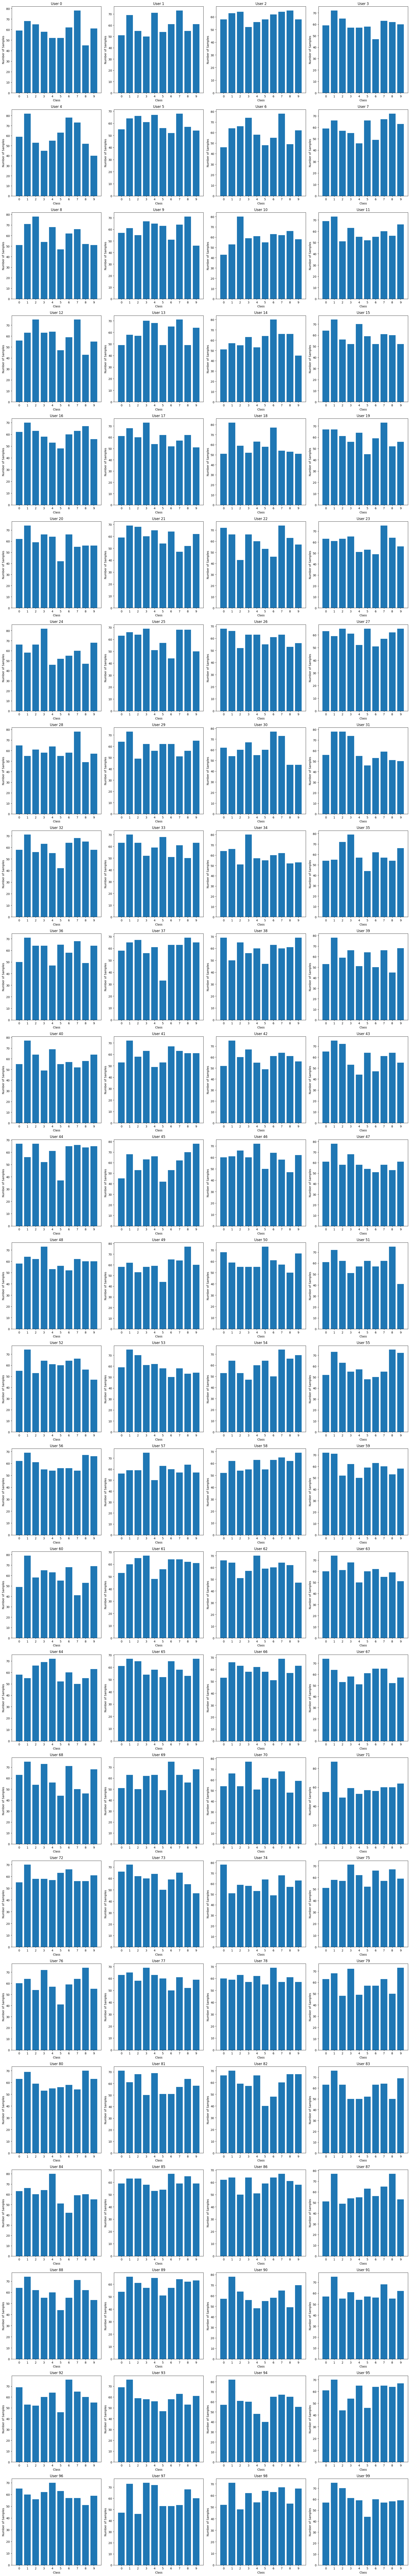

Round 1/20 - Accuracy: 10.81%
Round 2/20 - Accuracy: 10.95%
Round 3/20 - Accuracy: 16.00%
Round 4/20 - Accuracy: 16.17%
Round 5/20 - Accuracy: 14.68%
Round 6/20 - Accuracy: 12.64%
Round 7/20 - Accuracy: 13.18%
Round 8/20 - Accuracy: 10.23%
Round 9/20 - Accuracy: 11.29%
Round 10/20 - Accuracy: 11.06%
Round 11/20 - Accuracy: 12.33%
Round 12/20 - Accuracy: 12.16%
Round 13/20 - Accuracy: 12.89%
Round 14/20 - Accuracy: 18.58%
Round 15/20 - Accuracy: 18.48%
Round 16/20 - Accuracy: 23.60%
Round 17/20 - Accuracy: 19.73%
Round 18/20 - Accuracy: 28.90%
Round 19/20 - Accuracy: 36.73%
Round 20/20 - Accuracy: 36.36%


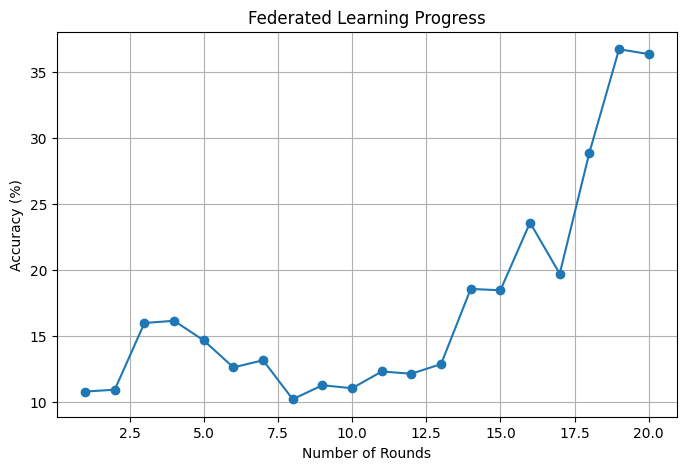

In [ ]:
if __name__ == "__main__":
    # Load dataset and calculate distributions (optional for debugging)
    train_loaders, test_loader, train_data, user_data = load_dataset_and_loaders()
    calculate_and_plot_class_distribution(train_data, user_data)

    # Run federated training for the default parameters
    global_model = federated_training(
        num_rounds=num_rounds,
        num_clients=num_clients,
        client_fraction=client_fraction,
        local_epochs=local_epochs,
        train_loaders=train_loaders,
        test_loader=test_loader,
        lr=learning_rate
    )


# Task 2: Training with different numbers of rounds (20, 30, 40)




Training for 20 rounds...
Round 1/20 - Accuracy: 9.94%
Round 2/20 - Accuracy: 10.17%
Round 3/20 - Accuracy: 10.18%
Round 4/20 - Accuracy: 10.32%
Round 5/20 - Accuracy: 10.57%
Round 6/20 - Accuracy: 10.73%
Round 7/20 - Accuracy: 10.38%
Round 8/20 - Accuracy: 11.51%
Round 9/20 - Accuracy: 11.74%
Round 10/20 - Accuracy: 13.71%
Round 11/20 - Accuracy: 15.86%
Round 12/20 - Accuracy: 18.11%
Round 13/20 - Accuracy: 19.85%
Round 14/20 - Accuracy: 21.57%
Round 15/20 - Accuracy: 23.09%
Round 16/20 - Accuracy: 24.81%
Round 17/20 - Accuracy: 25.85%
Round 18/20 - Accuracy: 26.90%
Round 19/20 - Accuracy: 29.19%
Round 20/20 - Accuracy: 28.08%


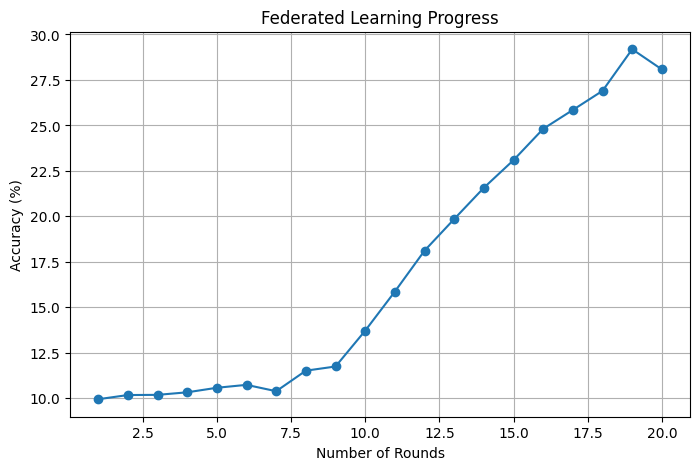


Training for 30 rounds...
Round 1/30 - Accuracy: 10.42%
Round 2/30 - Accuracy: 12.95%
Round 3/30 - Accuracy: 13.04%
Round 4/30 - Accuracy: 14.34%
Round 5/30 - Accuracy: 14.92%
Round 6/30 - Accuracy: 15.92%
Round 7/30 - Accuracy: 16.00%
Round 8/30 - Accuracy: 13.47%
Round 9/30 - Accuracy: 13.30%
Round 10/30 - Accuracy: 16.70%
Round 11/30 - Accuracy: 21.57%
Round 12/30 - Accuracy: 22.09%
Round 13/30 - Accuracy: 22.38%
Round 14/30 - Accuracy: 18.47%
Round 15/30 - Accuracy: 22.05%
Round 16/30 - Accuracy: 24.35%
Round 17/30 - Accuracy: 24.45%
Round 18/30 - Accuracy: 26.50%
Round 19/30 - Accuracy: 26.39%
Round 20/30 - Accuracy: 29.79%
Round 21/30 - Accuracy: 32.96%
Round 22/30 - Accuracy: 37.70%
Round 23/30 - Accuracy: 37.82%
Round 24/30 - Accuracy: 39.96%
Round 25/30 - Accuracy: 38.51%
Round 26/30 - Accuracy: 41.61%
Round 27/30 - Accuracy: 44.37%
Round 28/30 - Accuracy: 45.55%
Round 29/30 - Accuracy: 47.69%
Round 30/30 - Accuracy: 49.67%


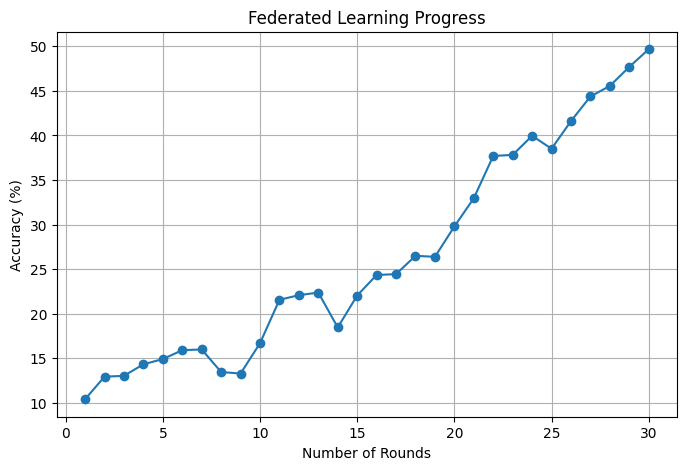


Training for 40 rounds...
Round 1/40 - Accuracy: 10.44%
Round 2/40 - Accuracy: 10.76%
Round 3/40 - Accuracy: 10.43%
Round 4/40 - Accuracy: 10.33%
Round 5/40 - Accuracy: 11.25%
Round 6/40 - Accuracy: 11.64%
Round 7/40 - Accuracy: 11.65%
Round 8/40 - Accuracy: 12.39%
Round 9/40 - Accuracy: 12.15%
Round 10/40 - Accuracy: 12.78%
Round 11/40 - Accuracy: 13.59%
Round 12/40 - Accuracy: 18.80%
Round 13/40 - Accuracy: 21.33%
Round 14/40 - Accuracy: 23.51%
Round 15/40 - Accuracy: 24.55%
Round 16/40 - Accuracy: 25.39%
Round 17/40 - Accuracy: 24.49%
Round 18/40 - Accuracy: 24.31%
Round 19/40 - Accuracy: 26.12%
Round 20/40 - Accuracy: 26.10%
Round 21/40 - Accuracy: 27.40%
Round 22/40 - Accuracy: 27.11%
Round 23/40 - Accuracy: 28.08%
Round 24/40 - Accuracy: 28.58%
Round 25/40 - Accuracy: 28.97%
Round 26/40 - Accuracy: 29.20%
Round 27/40 - Accuracy: 29.91%
Round 28/40 - Accuracy: 30.20%
Round 29/40 - Accuracy: 31.19%
Round 30/40 - Accuracy: 32.54%
Round 31/40 - Accuracy: 35.40%
Round 32/40 - Accurac

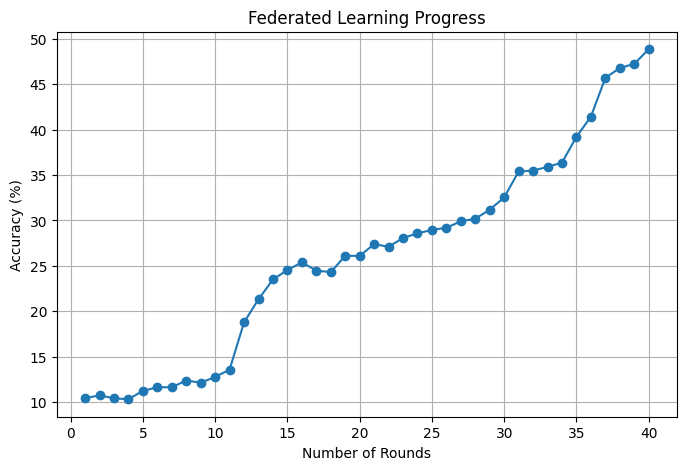


Task 2 Results (Accuracy at Final Round):
Rounds: 20 | Final Accuracy: 28.08%
Rounds: 30 | Final Accuracy: 49.67%
Rounds: 40 | Final Accuracy: 48.85%


In [ ]:
# Set parameters for Task 2
num_clients = 60
local_epochs = 1
learning_rate = 0.001

# Run experiments for different numbers of rounds
rounds_list = [20, 30, 40]
task_2_results = {}

for rounds in rounds_list:
    print(f"\nTraining for {rounds} rounds...")
    global_model = federated_training(
        num_rounds=rounds,
        num_clients=num_clients,
        client_fraction=0.1,  # Default client fraction
        local_epochs=local_epochs,
        train_loaders=train_loaders,
        test_loader=test_loader,
        lr=learning_rate
    )
    task_2_results[rounds] = test_model(global_model, test_loader)

# Summary of results
print("\nTask 2 Results (Accuracy at Final Round):")
for rounds, acc in task_2_results.items():
    print(f"Rounds: {rounds} | Final Accuracy: {acc:.2f}%")


# Task 3: Training with different numbers of local epochs (1, 5, 10)


Training with 1 local epochs...
Round 1/20 - Accuracy: 14.03%
Round 2/20 - Accuracy: 15.21%
Round 3/20 - Accuracy: 15.83%
Round 4/20 - Accuracy: 17.17%
Round 5/20 - Accuracy: 17.10%
Round 6/20 - Accuracy: 20.06%
Round 7/20 - Accuracy: 21.50%
Round 8/20 - Accuracy: 23.39%
Round 9/20 - Accuracy: 25.58%
Round 10/20 - Accuracy: 27.66%
Round 11/20 - Accuracy: 28.51%
Round 12/20 - Accuracy: 28.51%
Round 13/20 - Accuracy: 31.53%
Round 14/20 - Accuracy: 32.99%
Round 15/20 - Accuracy: 34.40%
Round 16/20 - Accuracy: 41.61%
Round 17/20 - Accuracy: 43.75%
Round 18/20 - Accuracy: 45.91%
Round 19/20 - Accuracy: 48.09%
Round 20/20 - Accuracy: 48.33%


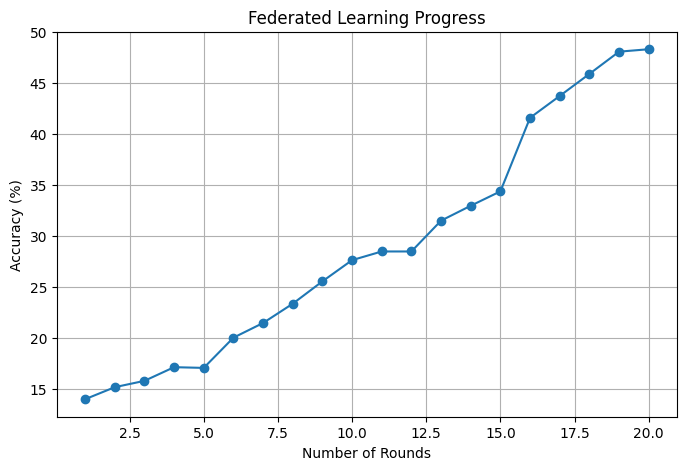


Training with 5 local epochs...
Round 1/20 - Accuracy: 13.37%
Round 2/20 - Accuracy: 20.53%
Round 3/20 - Accuracy: 18.67%
Round 4/20 - Accuracy: 13.26%
Round 5/20 - Accuracy: 21.64%
Round 6/20 - Accuracy: 35.41%
Round 7/20 - Accuracy: 42.16%
Round 8/20 - Accuracy: 47.27%
Round 9/20 - Accuracy: 46.14%
Round 10/20 - Accuracy: 50.22%
Round 11/20 - Accuracy: 54.81%
Round 12/20 - Accuracy: 61.76%
Round 13/20 - Accuracy: 64.57%
Round 14/20 - Accuracy: 63.20%
Round 15/20 - Accuracy: 63.28%
Round 16/20 - Accuracy: 67.51%
Round 17/20 - Accuracy: 66.49%
Round 18/20 - Accuracy: 68.84%
Round 19/20 - Accuracy: 71.67%
Round 20/20 - Accuracy: 71.96%


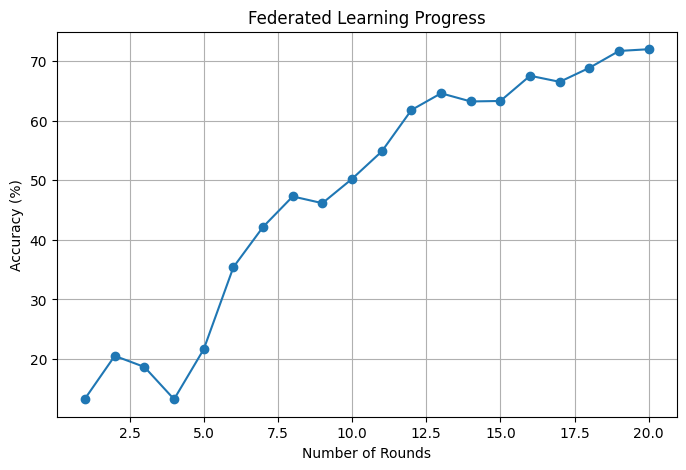


Training with 10 local epochs...
Round 1/20 - Accuracy: 20.10%
Round 2/20 - Accuracy: 39.15%
Round 3/20 - Accuracy: 56.67%
Round 4/20 - Accuracy: 56.38%
Round 5/20 - Accuracy: 59.28%
Round 6/20 - Accuracy: 66.41%
Round 7/20 - Accuracy: 65.47%
Round 8/20 - Accuracy: 67.51%
Round 9/20 - Accuracy: 74.53%
Round 10/20 - Accuracy: 76.90%
Round 11/20 - Accuracy: 79.11%
Round 12/20 - Accuracy: 81.78%
Round 13/20 - Accuracy: 83.21%
Round 14/20 - Accuracy: 84.59%
Round 15/20 - Accuracy: 85.12%
Round 16/20 - Accuracy: 86.30%
Round 17/20 - Accuracy: 87.09%
Round 18/20 - Accuracy: 87.72%
Round 19/20 - Accuracy: 88.30%
Round 20/20 - Accuracy: 88.67%


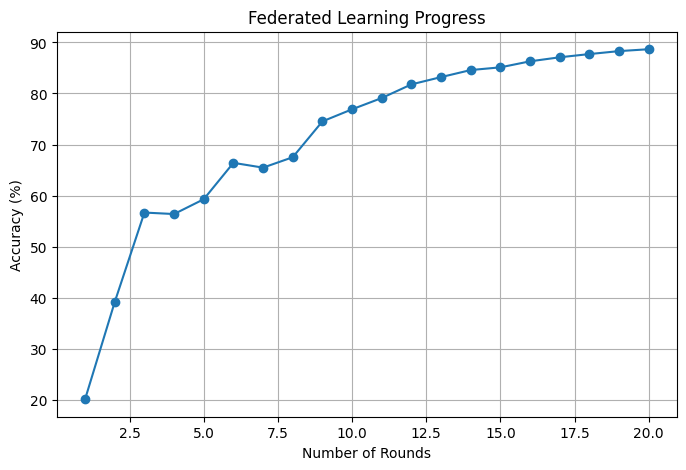


Task 3 Results (Accuracy at Final Round):
Local Epochs: 1 | Final Accuracy: 48.33%
Local Epochs: 5 | Final Accuracy: 71.96%
Local Epochs: 10 | Final Accuracy: 88.67%


In [ ]:
# Set parameters for Task 3
num_rounds = 20
num_clients = 60
learning_rate = 0.001

# Run experiments for different numbers of local epochs
epochs_list = [1, 5, 10]
task_3_results = {}

for epochs in epochs_list:
    print(f"\nTraining with {epochs} local epochs...")
    global_model = federated_training(
        num_rounds=num_rounds,
        num_clients=num_clients,
        client_fraction=0.1,  # Default client fraction
        local_epochs=epochs,
        train_loaders=train_loaders,
        test_loader=test_loader,
        lr=learning_rate
    )
    task_3_results[epochs] = test_model(global_model, test_loader)

# Summary of results
print("\nTask 3 Results (Accuracy at Final Round):")
for epochs, acc in task_3_results.items():
    print(f"Local Epochs: {epochs} | Final Accuracy: {acc:.2f}%")


# Task 4: Training with different client fractions (0.01, 0.05, 0.1)




Training with client fraction 0.01...
Round 1/20 - Accuracy: 11.05%
Round 2/20 - Accuracy: 12.45%
Round 3/20 - Accuracy: 14.45%
Round 4/20 - Accuracy: 16.32%
Round 5/20 - Accuracy: 19.16%
Round 6/20 - Accuracy: 20.44%
Round 7/20 - Accuracy: 23.12%
Round 8/20 - Accuracy: 24.40%
Round 9/20 - Accuracy: 25.69%
Round 10/20 - Accuracy: 24.92%
Round 11/20 - Accuracy: 26.10%
Round 12/20 - Accuracy: 28.42%
Round 13/20 - Accuracy: 29.27%
Round 14/20 - Accuracy: 31.39%
Round 15/20 - Accuracy: 32.46%
Round 16/20 - Accuracy: 33.69%
Round 17/20 - Accuracy: 34.49%
Round 18/20 - Accuracy: 33.19%
Round 19/20 - Accuracy: 31.46%
Round 20/20 - Accuracy: 31.63%


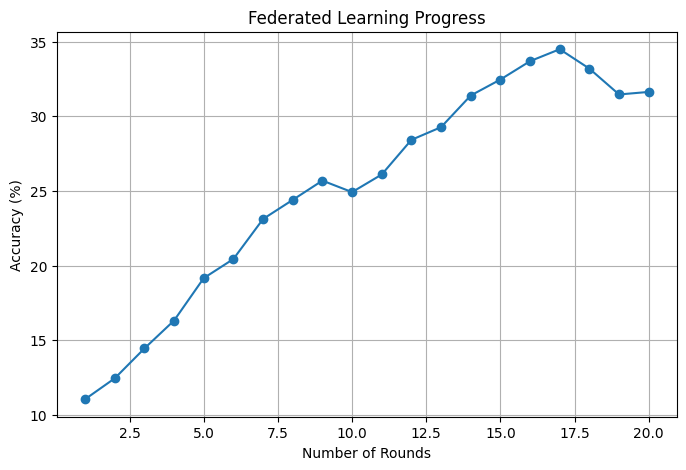


Training with client fraction 0.05...
Round 1/20 - Accuracy: 17.29%
Round 2/20 - Accuracy: 18.62%
Round 3/20 - Accuracy: 21.90%
Round 4/20 - Accuracy: 24.31%
Round 5/20 - Accuracy: 24.36%
Round 6/20 - Accuracy: 25.33%
Round 7/20 - Accuracy: 25.75%
Round 8/20 - Accuracy: 25.77%
Round 9/20 - Accuracy: 25.42%
Round 10/20 - Accuracy: 24.93%
Round 11/20 - Accuracy: 25.67%
Round 12/20 - Accuracy: 25.08%
Round 13/20 - Accuracy: 25.48%
Round 14/20 - Accuracy: 24.77%
Round 15/20 - Accuracy: 24.80%
Round 16/20 - Accuracy: 24.48%
Round 17/20 - Accuracy: 25.29%
Round 18/20 - Accuracy: 25.92%
Round 19/20 - Accuracy: 27.03%
Round 20/20 - Accuracy: 27.86%


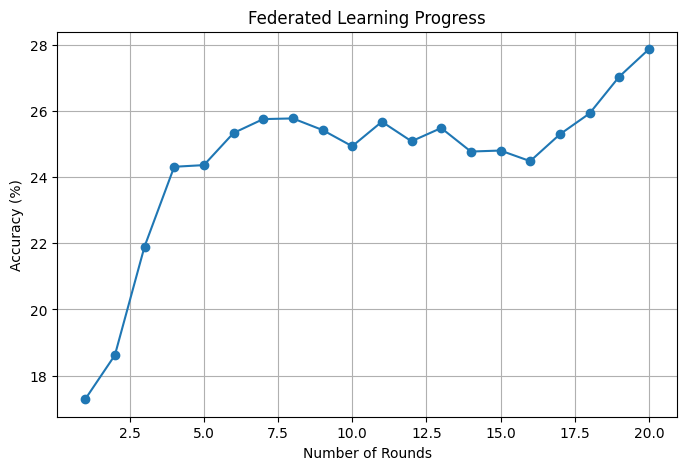


Training with client fraction 0.1...
Round 1/20 - Accuracy: 8.28%
Round 2/20 - Accuracy: 10.36%
Round 3/20 - Accuracy: 12.48%
Round 4/20 - Accuracy: 14.38%
Round 5/20 - Accuracy: 15.89%
Round 6/20 - Accuracy: 17.45%
Round 7/20 - Accuracy: 19.01%
Round 8/20 - Accuracy: 20.49%
Round 9/20 - Accuracy: 22.07%
Round 10/20 - Accuracy: 23.74%
Round 11/20 - Accuracy: 24.61%
Round 12/20 - Accuracy: 26.25%
Round 13/20 - Accuracy: 27.23%
Round 14/20 - Accuracy: 28.51%
Round 15/20 - Accuracy: 28.37%
Round 16/20 - Accuracy: 29.50%
Round 17/20 - Accuracy: 29.30%
Round 18/20 - Accuracy: 32.30%
Round 19/20 - Accuracy: 34.93%
Round 20/20 - Accuracy: 35.17%


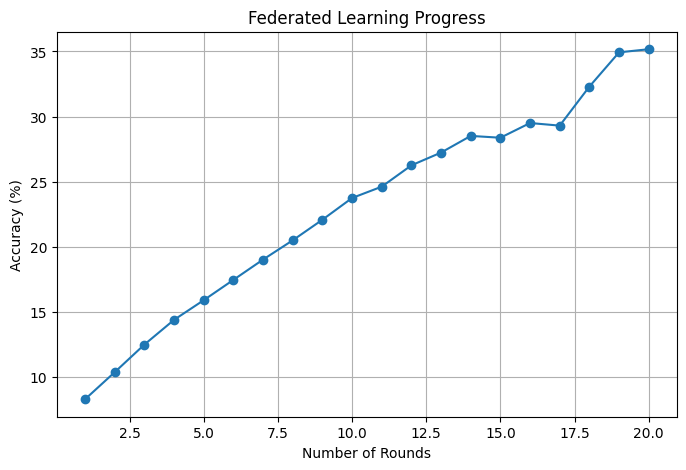


Task 4 Results (Accuracy at Final Round):
Client Fraction: 0.01 | Final Accuracy: 31.63%
Client Fraction: 0.05 | Final Accuracy: 27.86%
Client Fraction: 0.1 | Final Accuracy: 35.17%


In [11]:
# Set parameters for Task 4
num_rounds = 20
num_clients = 100
local_epochs = 1
learning_rate = 0.001

# Run experiments for different client fractions
fractions_list = [0.01, 0.05, 0.1]
task_4_results = {}

for fraction in fractions_list:
    print(f"\nTraining with client fraction {fraction}...")
    global_model = federated_training(
        num_rounds=num_rounds,
        num_clients=num_clients,
        client_fraction=fraction,
        local_epochs=local_epochs,
        train_loaders=train_loaders,
        test_loader=test_loader,
        lr=learning_rate
    )
    task_4_results[fraction] = test_model(global_model, test_loader)

# Summary of results
print("\nTask 4 Results (Accuracy at Final Round):")
for fraction, acc in task_4_results.items():
    print(f"Client Fraction: {fraction} | Final Accuracy: {acc:.2f}%")


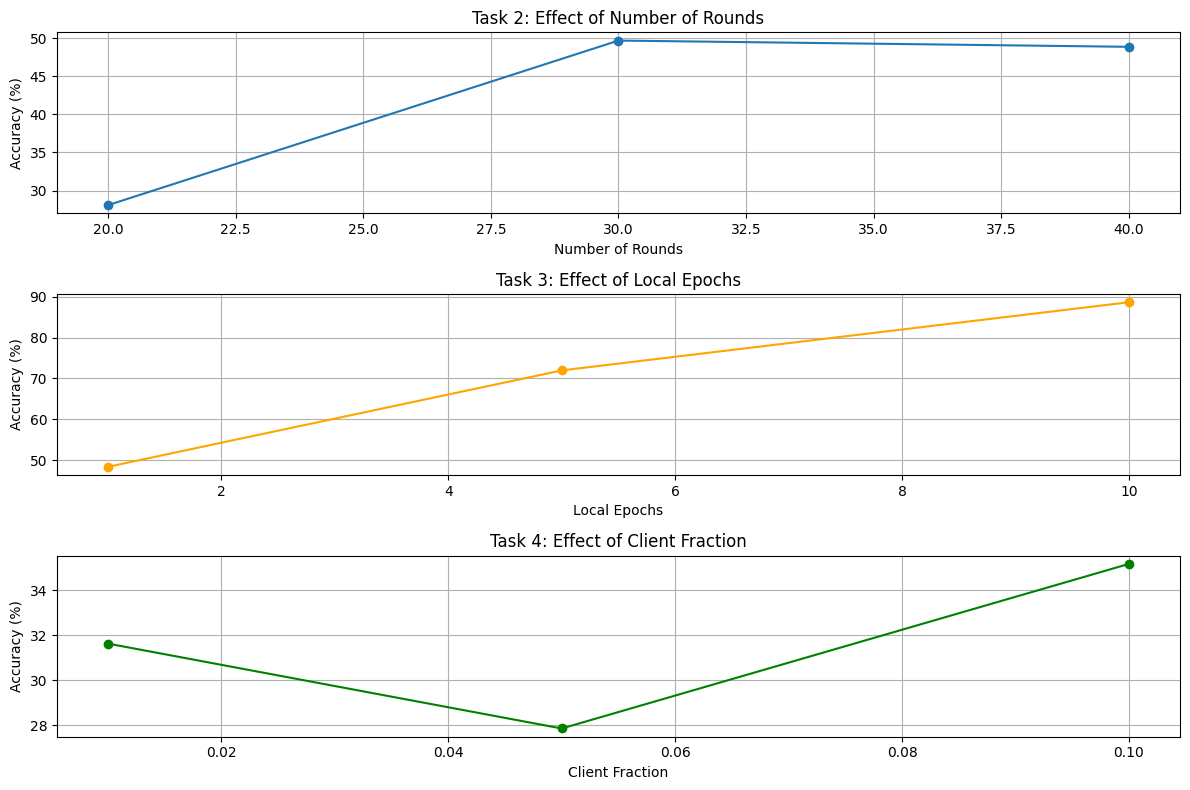

In [12]:
# Visualization of Results (Tasks 2, 3, and 4)
plt.figure(figsize=(12, 8))

# Task 2: Plot results for number of rounds
plt.subplot(3, 1, 1)
rounds, accuracies = zip(*task_2_results.items())
plt.plot(rounds, accuracies, marker='o', label='Task 2')
plt.title("Task 2: Effect of Number of Rounds")
plt.xlabel("Number of Rounds")
plt.ylabel("Accuracy (%)")
plt.grid(True)

# Task 3: Plot results for local epochs
plt.subplot(3, 1, 2)
epochs, accuracies = zip(*task_3_results.items())
plt.plot(epochs, accuracies, marker='o', color='orange', label='Task 3')
plt.title("Task 3: Effect of Local Epochs")
plt.xlabel("Local Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)

# Task 4: Plot results for client fraction
plt.subplot(3, 1, 3)
fractions, accuracies = zip(*task_4_results.items())
plt.plot(fractions, accuracies, marker='o', color='green', label='Task 4')
plt.title("Task 4: Effect of Client Fraction")
plt.xlabel("Client Fraction")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()
